# kallisto bus dataset comparison summary maker

This notebook takes the output files produced by kallisto bus and Cell Ranger and produces an 8 panel plot summary comparing the two.
Note that we need both the raw and filtered Cell Ranger output matrices, because because we use the filtered barcodes chosen by Cell Ranger for the comparison, so for the t-SNE embeddings we're only looking at the cells that Cell Ranger chose, and their counterparts (the ones with the same barcodes) in the kallisto output.

Some parts of this notebook can take a while to run (particularly the barcode distance calculations and t-SNE on full concatenated matrices)
If you plan on running several datasets, it is a better idea to use it as a python script. You can convert it to python with this jupyter terminal command:
!jupyter nbconvert --to script notebook-name.ipynb

The cell defining `dataset_dict` has one entry for each 



The following naming is expected for the kallisto files:
```
genes.mtx             - kallisto gene count matrix
genes.barcodes.txt    - kallisto barcode labels
genes.genes.txt       - kallisto gene labels
```
The following naming is expected for the Cell Ranger filtered and raw output files:
```
matrix.mtx.gz     - Cell Ranger count matrix
barcodes.tsv.gz   - Cell Ranger barcode labels
features.tsv.gz   - Cell Ranger gene labels
```

To easily manipulate these sparse matrices with annotations we usue the great AnnData (annotated data) structure
It's great, read about it here:
https://icb-anndata.readthedocs-hosted.com/en/latest/anndata.AnnData.html


## The notebook will produce an 8 panel figure with the following plots


#### A) Knee plot 
x axis: kallisto UMI counts
y axis: Cumulative number of barcodes 
Dashed lines and different in the colors mark the thresold of filtered barcodes.
The x and y axis are flipped compared to how most people make these plots.


#### B) Barcode ratio plot
x axis: kallisto UMI counts
y axis: Cell Ranger UMI counts
Retained barcodes are black, discarded ones are gray


#### C) Genes vs UMIs plot
x axis: kallisto UMI counts
y axis: Genes detected
Retained barcodes are darker, discarded ones are dimmer
Colored by kallisto or Cell Ranger


#### D) Correlation plot
x axis: kallisto UMI counts
y axis: Pearson correlation between Cell Ranger and kallisto counts for that barcode
Retained barcodes are darker, discarded ones are dimmer


#### E) Barcode distance histogram
x axis: L1 distance in log transformed gene count space
y axis: Closest barcode in L1 distance 
Colored by kallisto or Cell Ranger

#### F) Pinplot of t-SNE on full concatenated kallisto and Cell Ranger matrix
A line connects the kallisto barcodes (•) to the location of corresponding Cell Ranger barcodes
This t-SNE is calculated on the FULL log transformed gene count matrix
(that is, natural logarithm of one plus the original entry of the matrix elementwise)
Thus if the original matrices have 2000 cells and 30000 genes each for kallisto and Cell Ranger,
the concatenated matrix will be 4000x30000.
This can take a while (hours) for large matrices, better done in a server rather than your desktop

#### G) t-SNE on top 10 truncated SVD components for kallisto and Cell Ranger Matrices
Left side:  kallisto t-SNE
Right side: Cell Ranger t-SNE

#### H) Differentially expressed genes
This analysis was done in R, here we just load the CSV file to produce this bar plot
See the relevant R code to see how the analysis was done.








In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import copy
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
import scipy
import anndata
from matplotlib.pyplot import figure
from sklearn.decomposition import TruncatedSVD
import sklearn
import anndata
import time
from openTSNE import TSNE
import openTSNE
from openTSNE.callbacks import ErrorLogger
import datetime
from anndata import AnnData
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
import matplotlib.pyplot as plt
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

## Choose dataset to process

In [2]:
# Uncomment one dataset to process in the notebook
# If you want to process several in a for loop you should convert the notebook into a python script using
# !jupyter nbconvert --to script notebook-name.ipynb


dataset_dict = {
'heart1k_v2': ' 1k Heart Cells from an E18 mouse (v2 chemistry)',    
# 'hgmm1k_v2': ' 1k 1:1 Mixture of Fresh Frozen Human (HEK293T) and Mouse (NIH3T3) Cells (v2 chemistry)',
# 'EMTAB7320_v2': 'E-MTAB-7320 E-MTAB-7320 - Single-cell RNA-seq of mouse developing spinal cord',
# 'heart1k_v3': ' 1k Heart Cells from an E18 mouse (v3 chemistry)',
# 'hgmm1k_v3': ' 1k 1:1 Mixture of Fresh Frozen Human (HEK293T) and Mouse (NIH3T3) Cells (v3 chemistry)',
# 'hgmm10k_v3': ' 10k 1:1 Mixture of Fresh Frozen Human (HEK293T) and Mouse (NIH3T3) Cells (v3 chemistry)',
# 'neuron10k_v3': ' 10k Brain Cells from an E18 Mouse (v3 chemistry)',
# 'pbmc10k_v3': ' 10k PBMCs from a Healthy Donor (v3 chemistry)',
# 'pbmc1k_v3': ' 1k PBMCs from a Healthy Donor (v3 chemistry)',
# 'SRR6956073_v2': 'SRR6956073 GSM3084402: WT zebrafish embryo (6-somite); Danio rerio \n 10x analysis of wild-type (TLAB) and MZoep zebrafish embryos at 6-somite stage',
# 'SRR6998058_v2': 'SRR6998058 GSM3097063: Inf_rep1; Mus musculus; \n  sc-RNA sequencing of skeletal muscle macrophages during T. gondii infection and injury',
# 'SRR7299563_v2': 'SRR7299563 GSM3188351: Pineal_Gland_Vehicle_Control; Rattus norvegicus; \n Single-cell RNA sequencing of the mammalian pineal gland identifies two pinealocyte subtypes and cell type-specific daily patterns of gene expression',
# 'SRR7692543_v2': 'SRR7692543 GSM3332260: M1Fovea1; Macaca fascicularis; \n Molecular specification of cell types underlying central and peripheral vision in primates (macaque fovea single cell RNA-seq)',
# 'SRR8206317_v2': 'SRR8206317 GSM3477862: d10_Tet; Mus musculus; \n 10X single-cell RNASeq profiling of tumor-infiltrating CD8+ T-cells from B16-OVA mouse melanoma tumors',
# 'SRR8257100_v2': 'SRR8257100 GSM3490689: WT_rep1; Arabidopsis thaliana; \n Single-cell RNA-sequencing analysis of Arabidopsis roots',
# 'SRR8327928_v2': 'SRR8327928 GSM3516947: Patient derived xenograft 110; Homo sapiens;  \n Single cell RNA-seq of 25 thousand epithelial cells from xenografts of triple-negative breast cancers',
# 'SRR8513910_v2': 'SRR8513910 GSM3585578: Third instar larval ovary dissociated with Trypsin and Collagenase rep 1; \n Drosophila melanogaster; Drosophila melanogaster female late third instar larval gonads single-cell RNA-Seq (scRNA-Seq) profiling',
# 'SRR8524760_v2': 'SRR8524760 GSM3589358: KS_10X_iPSC_KS1_K1-1_scRNA-seq; Homo sapiens; \n Single-cell transcription profiling in KS1 patient iPSCs and NPCs',
# 'SRR8599150_v2': 'SRR8599150 GSM3612831: ctrl; Mus musculus; \n Single cell RNA-seq identifies a unique microglia subtype associated with retinal degeneration',
# 'SRR8611943_v2': 'SRR8611943 GSM3618670: UW synchronized 300 min post bleach; Caenorhabditis elegans; \n A lineage-resolved molecular atlas of C. elegans embryogenesis at single cell resolution',
# 'SRR8639063_v2': 'SRR8639063 GSM3629848: 10x_osk_esc; Mus musculus; \n Resolving Cell Fate Decisions during Somatic Cell Reprogramming by Single-Cell RNA-seq'
}

In [3]:
# You need to adjust the path to match where the data is
# We need folders for the kallisto output, Cell Ranger raw matrices, and Cell Ranger filtered matrices
for dataset_shortname in dataset_dict:
    dataset_name = dataset_dict[dataset_shortname]
    print('----------------------------PROCESING DATASET ------------------------------')
    print(dataset_shortname)
    print(dataset_dict[dataset_shortname])
    print(datetime.datetime.now())
    print('----------------------------PROCESING DATASET ------------------------------')


    kallisto_folder = '/home/munfred/single_cell_analysis/kallisto_out_single/kallisto_' + dataset_shortname
    tenx_folder = '/home/munfred/single_cell_analysis/cellranger_out/cellranger3_' + dataset_shortname +'_out/outs/filtered_feature_bc_matrix'
    raw_folder = '/home/munfred/single_cell_analysis/cellranger_out/cellranger3_' + dataset_shortname +'_out/outs/raw_feature_bc_matrix'
    
    # these if statements were needed because we had some inconsistencies when naming outputs...
    if dataset_shortname == 'pbmc1k_v3': kallisto_folder = '/home/munfred/single_cell_analysis/kallisto_out_single/kallisto_pbmc_1k_v3' 
    if dataset_shortname == 'pbmc10k_v3': kallisto_folder = '/home/munfred/single_cell_analysis/kallisto_out_single/kallisto_pbmc_10k_v3' 
    if dataset_shortname == 'neuron10k_v3': kallisto_folder = '/home/munfred/single_cell_analysis/kallisto_out_single/kallisto_neuron_10k_v3' 
 

----------------------------PROCESING DATASET ------------------------------
heart1k_v2
 1k Heart Cells from an E18 mouse (v2 chemistry)
2019-06-05 00:32:27.587497
----------------------------PROCESING DATASET ------------------------------


## Load kallisto and Cell Ranger .mtx into anndata

In [4]:
# load 10x on anndata as sparse csr matrix
tenx_filtered = anndata.AnnData(scipy.io.mmread(os.path.join(tenx_folder,'matrix.mtx.gz')).tocsr().T)
tenxs_barcodes = pd.read_csv(os.path.join(tenx_folder,'barcodes.tsv.gz'), index_col = 0, header = None, names = ['barcode'])
tenxs_barcodes.index = tenxs_barcodes.index.str.slice(0,16,1)
tenx_filtered.obs= tenxs_barcodes
tenx_filtered.var = pd.read_csv(os.path.join(tenx_folder,'features.tsv.gz'), header = None, index_col = 0, names =['ensembl_id', 'gene_name', 'kind'], sep = '\t')
print('Loaded tenx filtered mtx:',tenx_filtered.X.shape)

## load kallisto on anndata as sparse crs matrix
kallisto_raw = anndata.AnnData(scipy.io.mmread(os.path.join(kallisto_folder,'genes.mtx')).tocsr())
kallisto_raw.obs= pd.read_csv(os.path.join(kallisto_folder,'genes.barcodes.txt'), index_col = 0, header = None, names = ['barcode'])
kallisto_raw.var = pd.read_csv(os.path.join(kallisto_folder,'genes.genes.txt'), header = None, index_col = 0, names =['ensembl_id'], sep = '\t')
print('Loaded kallisto raw mtx:',kallisto_raw.X.shape)
kallisto_filtered = kallisto_raw[tenx_filtered.obs.index.values]

# load tenx raw matrix
tenx_raw = anndata.AnnData(scipy.io.mmread(os.path.join(raw_folder,'matrix.mtx.gz')).tocsr().T)
tenxs_barcodes = pd.read_csv(os.path.join(raw_folder,'barcodes.tsv.gz'), index_col = 0, header = None, names = ['barcode'])
tenxs_barcodes.index = tenxs_barcodes.index.str.slice(0,16,1)
tenx_raw.obs= tenxs_barcodes
tenx_raw.var = pd.read_csv(os.path.join(raw_folder,'features.tsv.gz'), header = None, index_col = 0, names =['ensembl_id', 'gene_name', 'kind'], sep = '\t')
print('Loaded tenx raw mtx:',tenx_raw.X.shape)



Loaded tenx filtered mtx: (712, 31053)
Loaded kallisto raw mtx: (196708, 31053)
Loaded tenx raw mtx: (737280, 31053)


In [5]:
# truncdates the ensembl version number off the kallisto labels
kallisto_raw.var['full_emsembl_id'] = kallisto_raw.var.index
kallisto_raw.var.index = kallisto_raw.var['full_emsembl_id'].str.slice(0,18)
kallisto_filtered.var['full_emsembl_id'] = kallisto_filtered.var.index
kallisto_filtered.var.index = kallisto_filtered.var['full_emsembl_id'].str.slice(0,18)

In [6]:
# there are some mismatches with the gene names in the species mixing data 
# that require this undoing of the reindexing
# (skipping this cell would only break the correlation plot)

if dataset_shortname in ['hgmm1k_v2', 'hgmm1k_v3', 'hgmm10k_v3']:
    kallisto_raw.var.index = kallisto_raw.var['full_emsembl_id']
    kallisto_filtered.var.index = kallisto_filtered.var['full_emsembl_id']

In [7]:
#make alldata. its a pun on adata.
alldata =  AnnData.concatenate(tenx_filtered,kallisto_filtered, join='outer', batch_categories=['tenx','kallisto'],index_unique='-')
alldata.obs['orig_bc'] = alldata.obs.index.str.split('-').str.get(0)
# check the barcodes in all batches are the same in the same order
if np.array_equal(alldata[alldata.obs.query('batch == "tenx"').index].obs.head()['orig_bc'].values,
               alldata[alldata.obs.query('batch == "kallisto"').index].obs.head()['orig_bc'].values):
    print ('kallisto barcodes are good')
print(datetime.datetime.now())    

kallisto barcodes are good
2019-06-05 00:32:49.027630


## Compute total counts, genes, log transform

In [8]:
# count UMIs, genes, log transform concatenated filtered 10x and kallisto barcodes 
alldata.layers['log1p'] = np.log1p(alldata.X)
alldata.obs['counts'] = alldata.X.sum(1)
alldata.obs['ngenes'] = np.array((alldata.X > 0).sum(1))
alldata.obs['log10counts']=np.log10(alldata.obs['counts'])
print('kallisto and Cellranger concatenated filetered data:', alldata.shape)

kallisto and Cellranger concatenated filetered data: (1424, 31053)


In [9]:
# count UMIs, genes, log transform raw 10x barcodes  
# first remove kallisto barcodes with 0 gene counts

tenx_raw.obs['counts'] = tenx_raw.X.sum(1)
tenx_raw.obs['ngenes'] = np.array((tenx_raw.X > 0).sum(1))
tenx_raw = tenx_raw[tenx_raw.obs['counts'] > 0]
tenx_raw.layers['log1p'] = np.log1p(tenx_raw.X)
tenx_raw.obs['log10counts']=np.log10(tenx_raw.obs['counts'])
print('Cell Ranger raw:', tenx_raw.shape)

Cell Ranger raw: (189169, 31053)


In [10]:
# count UMIs, genes, log transform raw kallisto barcodes   
# first remove kallisto barcodes with 0 gene counts

kallisto_raw.obs['counts'] = kallisto_raw.X.sum(1)
kallisto_raw.obs['ngenes'] = np.array((kallisto_raw.X > 0).sum(1))
kallisto_raw = kallisto_raw[kallisto_raw.obs['counts'] > 0]
kallisto_raw.layers['log1p'] = np.log1p(kallisto_raw.X)
kallisto_raw.obs['log10counts']=np.log10(kallisto_raw.obs['counts'])
print('kallisto raw:', kallisto_raw.shape)

kallisto raw: (182040, 31053)


In [11]:
# make alldata. its a pun on adata. 
alldata_raw =  AnnData.concatenate(tenx_raw,kallisto_raw, join='outer', batch_categories=['tenx','kallisto'],index_unique='-')
alldata_raw.obs['orig_bc'] = alldata_raw.obs.index.str.split('-').str.get(0)
alldata_raw.layers['log1p'] = np.log1p(alldata_raw.X)

# check the barcodes in all batches are the same in the same order
if np.array_equal(alldata_raw[alldata_raw.obs.query('batch == "tenx"').index].obs.head()['orig_bc'].values,
               alldata_raw[alldata_raw.obs.query('batch == "kallisto"').index].obs.head()['orig_bc'].values):
    print ('joint raw barcodes are good')
print('Concatenated raw mtx:',alldata_raw.X.shape)
print(datetime.datetime.now())    

layers concatenation is not yet available for 'outer' intersection and will be ignored.


joint raw barcodes are good
Concatenated raw mtx: (371209, 31053)
2019-06-05 00:38:34.296876


In [12]:
# make views of each pipeline data for convenience
kallisto = alldata[alldata.obs.query('batch == "kallisto"').index]
tenx = alldata[alldata.obs.query('batch == "tenx"').index]
print('Made filtered views.')
print(datetime.datetime.now())

Made filtered views.
2019-06-05 00:38:34.359937


In [13]:
# make views of each pipeline data for convenience
kallisto_raw_view = alldata_raw[alldata_raw.obs.query('batch == "kallisto"').index]
tenx_raw_view = alldata_raw[alldata_raw.obs.query('batch == "tenx"').index]
print('Made raw views.')
print(datetime.datetime.now())

Made raw views.
2019-06-05 00:38:35.012967


# Check barcodes seen by kallisto, Cell Ranger, and both

In [14]:
# barcodes seen by either
joint_obs = kallisto_raw.obs.join(tenx_raw.obs,how = 'outer', lsuffix='-kallisto', rsuffix='-tenx')
joint_obs = joint_obs.fillna(0)
print('Total barcodes seen')
print(len(joint_obs))

# barcodes seen by both
common_obs = kallisto_raw.obs.join(tenx_raw.obs,how = 'inner', lsuffix='-kallisto', rsuffix='-tenx')
print('Barcodes seen by both')
print(len(common_obs))

# restrict joint obs to kallisto
kobs = kallisto_raw.obs.join(tenx_raw.obs,how = 'left', lsuffix='-kallisto', rsuffix='-tenx')
kobs = kobs.sort_values(by=['counts-kallisto'], ascending = False)
print('Barcodes seen by kallisto missed by Cell Ranger')
print(len(joint_obs) - len(kobs))

# just Cell Ranger observations
tobs = tenx_raw.obs.copy()
tobs=tobs.sort_values('counts', ascending = False)
print('Barcodes seen by Cell Ranger missed by kallisto')
print(len(joint_obs) - len(tobs))

Total barcodes seen
197451
Barcodes seen by both
173758
Barcodes seen by kallisto missed by Cell Ranger
15411
Barcodes seen by Cell Ranger missed by kallisto
8282


## Compute correlations between kallisto and Cell Ranger

In [15]:
# handy and fast function for computing correlation on sparse matrices
def sparse_M_std(X):
    n = X.shape[1]
    return np.sqrt(n * X.multiply(X).sum(1) - np.multiply(X.sum(1), X.sum(1)))

def sparse_M_corr(X,Y):
    X_std = sparse_M_std(X)
    Y_std = sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)
    
    n = X.shape[1]
    XY_cov = n* X.multiply(Y).sum(1) - np.multiply(X.sum(1), Y.sum(1))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

In [16]:
kallisto_raw_view.obs.index = kallisto_raw_view.obs['orig_bc']

In [17]:
tenx_raw_view.obs.index = tenx_raw_view.obs['orig_bc']

In [18]:
# Compute correlations. It's fairly quick
raw_counts_correlation = sparse_M_corr(kallisto_raw_view[common_obs.index].layers['log1p'],tenx_raw_view[common_obs.index].layers['log1p'])
filtered_counts_correlation = sparse_M_corr(kallisto_raw_view[tenx_filtered.obs.index].layers['log1p'],tenx_raw_view[tenx_filtered.obs.index].layers['log1p'])
print('Correlations computed!')

Correlations computed!


## Truncated SVD

In [19]:
# # Truncated SVD
# Do TSVD and keep 10 dimensions for t-SNE
tsvd = TruncatedSVD(n_components=10)
TSVD = tsvd.fit_transform(alldata.layers['log1p'])
alldata.obsm['TSVD'] = TSVD
alldata.obsm['TSVD']
print('TSVD variance ratios:\n', list(tsvd.explained_variance_ratio_))
print(datetime.datetime.now())

TSVD variance ratios:
 [0.36852267, 0.061328996, 0.02527526, 0.021343743, 0.01619124, 0.013016979, 0.011519339, 0.009754788, 0.00863312, 0.00802097]
2019-06-05 00:38:37.885801


## L1 barcode distance

In [20]:
print('Calculating L1 distances...')
kallisto = alldata[alldata.obs.query('batch == "kallisto"').index]
tenx = alldata[alldata.obs.query('batch == "tenx"').index]

# taking manhattan distance between matrices
dnck = manhattan_distances(tenx.layers['log1p'], kallisto.layers['log1p'])
dnkk = manhattan_distances(kallisto.layers['log1p'], kallisto.layers['log1p'])
print(datetime.datetime.now())

# nkc are the kallisto-cellranger distances 
nck = np.diagonal(dnck)

# ncc are the kallisto-kallisto distances
ncc = []
for row in dnkk:
    val = np.partition(row, 1)[1]
    ncc.append(val)
print('L1 distances done!')
print(datetime.datetime.now())

Calculating L1 distances...
2019-06-05 00:38:52.302555
L1 distances done!
2019-06-05 00:38:52.308362


# t-SNE on full matrix for kallisto and Cell Ranger

In [21]:
# This t-SNE is very slow and can sometimes take hours when processing thousands of cells
tsne = TSNE(perplexity=30, metric="euclidean", callbacks=openTSNE.callbacks.ErrorLogger(),n_jobs=24, initialization="random", random_state=42 )
alldata.obsm['TSNE-FULL'] = tsne.fit(alldata.layers['log1p'].toarray())

# if you want to save your adata to avoid reprocessing, uncomment the lines below
# alldata.write(os.path.join('./' + dataset_shortname + '.h5ad'))
# print('AnnData Saved.')

Iteration   50, KL divergence  3.2398, 50 iterations in 0.3375 sec
Iteration  100, KL divergence  3.1594, 50 iterations in 0.5159 sec
Iteration  150, KL divergence  3.1749, 50 iterations in 0.7682 sec
Iteration  200, KL divergence  3.2175, 50 iterations in 1.9685 sec
Iteration  250, KL divergence  3.1884, 50 iterations in 2.1189 sec
Iteration   50, KL divergence  1.1282, 50 iterations in 0.9740 sec
Iteration  100, KL divergence  0.9261, 50 iterations in 2.7409 sec
Iteration  150, KL divergence  0.8345, 50 iterations in 6.2241 sec
Iteration  200, KL divergence  0.7856, 50 iterations in 9.5746 sec
Iteration  250, KL divergence  0.7585, 50 iterations in 12.3253 sec
Iteration  300, KL divergence  0.7372, 50 iterations in 12.0197 sec
Iteration  350, KL divergence  0.7287, 50 iterations in 16.2334 sec
Iteration  400, KL divergence  0.7176, 50 iterations in 16.1730 sec
Iteration  450, KL divergence  0.7106, 50 iterations in 25.8152 sec
Iteration  500, KL divergence  0.7118, 50 iterations in 1

## t-SNE on kallisto top 10 PC

In [22]:
# Perform TSNE on top 10 truncated SVD components of kallisto filtered barcode matrix
print('Doing t-SNE on top 10 PC for kallisto')
kallisto_copy = kallisto.copy()
print('Doing t-SNE')
print(datetime.datetime.now())
tsne = TSNE(perplexity=30, metric="euclidean", callbacks=openTSNE.callbacks.ErrorLogger(),n_jobs=8, random_state=42, n_iter=750 )
kallisto_copy.obsm['TSNE10'] = tsne.fit(kallisto_copy.obsm['TSVD'])
print('kallisto TSNE-10 done.')
print(datetime.datetime.now())
# if you want to save your adata to avoid reprocessing, uncomment the lines below
#alldata.write(os.path.join('./' + dataset_shortname + '.h5ad'))
#print('AnnData Saved.')


Doing t-SNE on top 10 PC for kallisto
Doing t-SNE
2019-06-05 00:45:06.602223
Iteration   50, KL divergence  2.2062, 50 iterations in 0.2869 sec
Iteration  100, KL divergence  2.0354, 50 iterations in 0.3610 sec
Iteration  150, KL divergence  2.0438, 50 iterations in 0.4009 sec
Iteration  200, KL divergence  2.0516, 50 iterations in 0.4495 sec
Iteration  250, KL divergence  2.0119, 50 iterations in 0.3601 sec
Iteration   50, KL divergence  0.4223, 50 iterations in 0.5424 sec
Iteration  100, KL divergence  0.3795, 50 iterations in 1.5846 sec
Iteration  150, KL divergence  0.3672, 50 iterations in 2.2100 sec
Iteration  200, KL divergence  0.3588, 50 iterations in 2.6588 sec
Iteration  250, KL divergence  0.3541, 50 iterations in 3.6812 sec
Iteration  300, KL divergence  0.3524, 50 iterations in 4.2433 sec
Iteration  350, KL divergence  0.3496, 50 iterations in 4.9693 sec
Iteration  400, KL divergence  0.3492, 50 iterations in 3.8609 sec
Iteration  450, KL divergence  0.3464, 50 iterations

## t-SNE on Cell Ranger top 10 PC

In [23]:
# Perform TSNE on top 10 truncated SVD components of Cell Ranger filtered matrix
print('Doing t-SNE on top 10 PC for Cell Ranger')
tenx_copy = tenx.copy()

print(datetime.datetime.now())
tsne = TSNE(perplexity=30, metric="euclidean", callbacks=openTSNE.callbacks.ErrorLogger(),n_jobs=8, random_state=42, n_iter=750 )
tenx_copy.obsm['TSNE10'] = tsne.fit(tenx_copy.obsm['TSVD'])
print('Cell Ranger TSNE-10 done.')
print(datetime.datetime.now())
# if you want to save your adata uncomment the lines below
#alldata.write(os.path.join('./anndatas/' + dataset_shortname + '.h5ad'))
#print('AnnData Saved.')


Doing t-SNE on top 10 PC for Cell Ranger
2019-06-05 00:46:10.935676
Iteration   50, KL divergence  2.1362, 50 iterations in 0.2357 sec
Iteration  100, KL divergence  2.1043, 50 iterations in 0.4411 sec
Iteration  150, KL divergence  2.0655, 50 iterations in 0.8105 sec
Iteration  200, KL divergence  2.0349, 50 iterations in 0.4504 sec
Iteration  250, KL divergence  1.9765, 50 iterations in 0.5631 sec
Iteration   50, KL divergence  0.4199, 50 iterations in 0.6384 sec
Iteration  100, KL divergence  0.3803, 50 iterations in 1.6142 sec
Iteration  150, KL divergence  0.3653, 50 iterations in 2.0996 sec
Iteration  200, KL divergence  0.3572, 50 iterations in 2.8827 sec
Iteration  250, KL divergence  0.3521, 50 iterations in 3.2411 sec
Iteration  300, KL divergence  0.3484, 50 iterations in 3.2392 sec
Iteration  350, KL divergence  0.3459, 50 iterations in 5.2991 sec
Iteration  400, KL divergence  0.3435, 50 iterations in 3.8372 sec
Iteration  450, KL divergence  0.3413, 50 iterations in 3.366

# Make the plots

In [24]:
#very handy function from https://gist.github.com/ihincks/6a420b599f43fcd7dbd79d56798c4e5a

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


-----------PLOT SAVED!---------
2019-06-05 00:47:42.865336


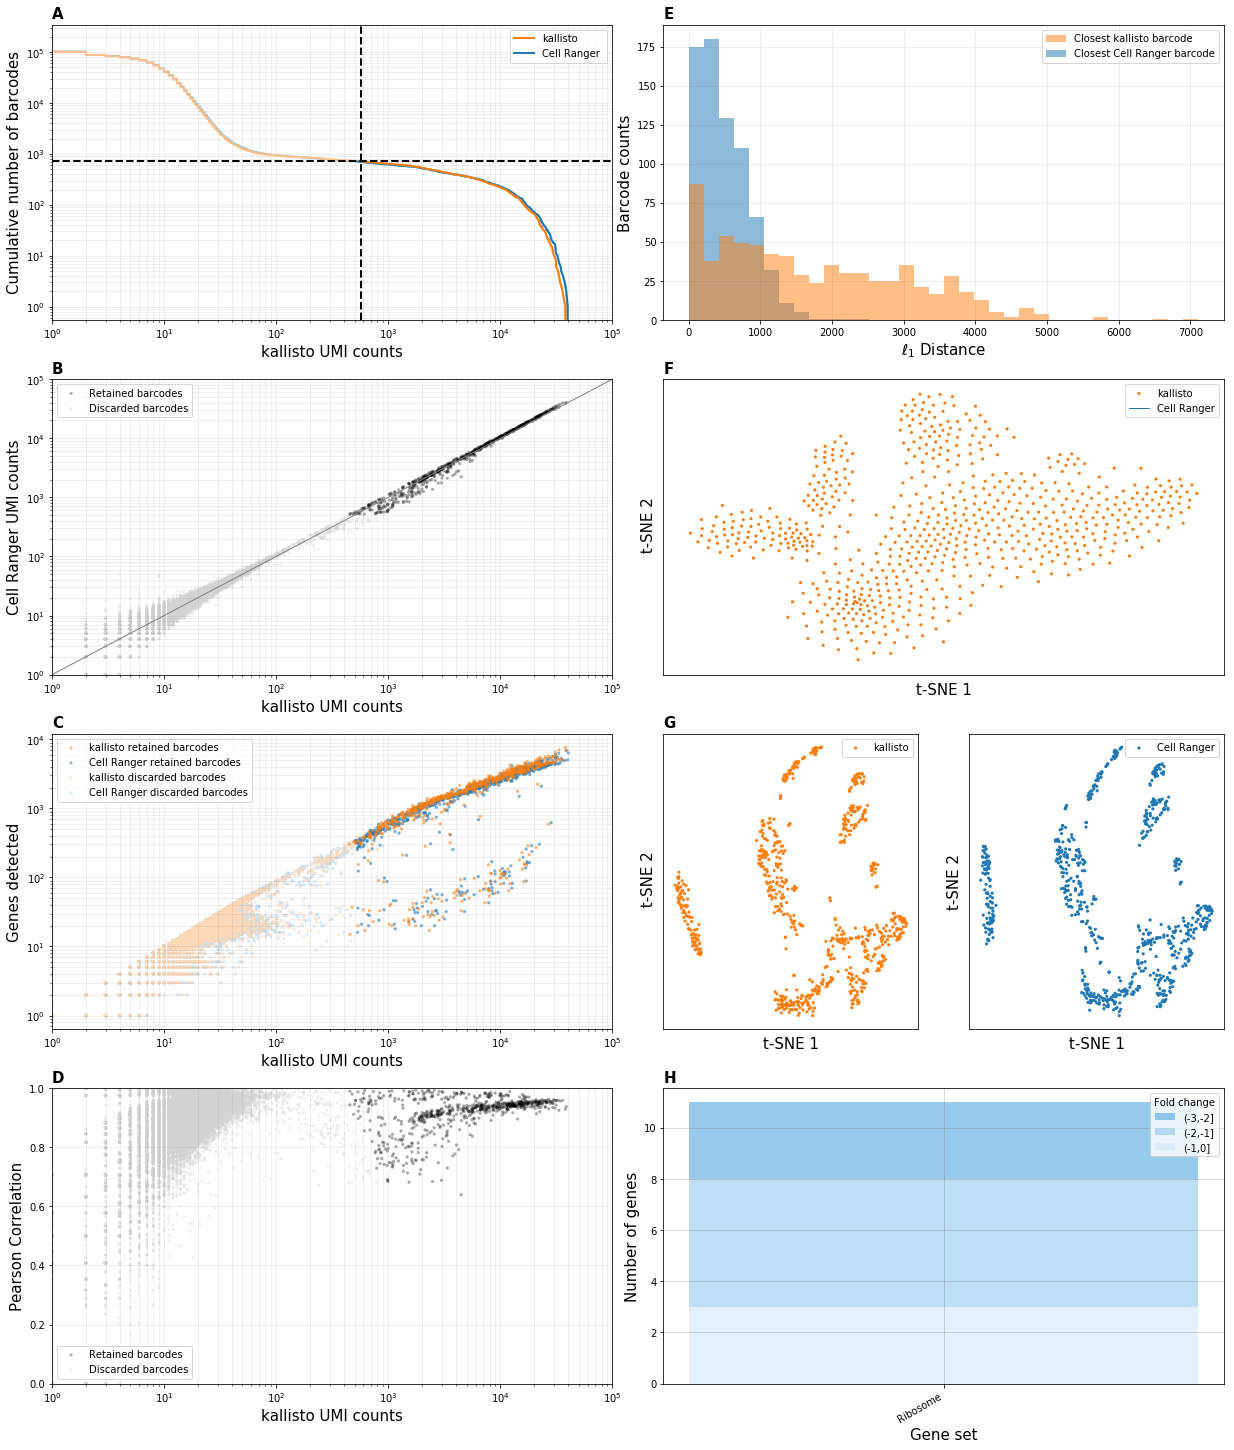

In [25]:
# define some values we use to keep the plots consistent
fsize= 15
kallisto_color = '#FF7F0E'
tenx_color = '#1F77B4'
dotsize = 10
xmax = 1e5
gridalpha = 0.2

# Make the figure with a 4x4 grid
# This is necessary so panel G can have left and right sides
fig = plt.figure(figsize=(21,25))
ax_a = plt.subplot2grid((4, 4), (0, 0), colspan=2)
ax_b = plt.subplot2grid((4, 4), (1, 0), colspan=2)
ax_c = plt.subplot2grid((4, 4), (2, 0), colspan=2)
ax_d = plt.subplot2grid((4, 4), (3, 0), colspan=2)
ax_e = plt.subplot2grid((4, 4), (0, 2), colspan=2)
ax_f = plt.subplot2grid((4, 4), (1, 2), colspan=2)
ax_g_left = plt.subplot2grid((4, 4), (2, 2), colspan=1)
ax_g_right = plt.subplot2grid((4, 4), (2, 3), colspan=1)
ax_h = plt.subplot2grid((4, 4), (3, 2), colspan=2)

# Now we make the plots

# A ###  KNEE PLOT ##########
loc = ax_a

tenx_ranked_umi = np.sort(np.array(tenx_raw.X.sum(1)), axis=None)[::-1]
loc.plot( tenx_ranked_umi, np.arange(len(tenx_ranked_umi)),
         c = lighten_color(tenx_color, 0.5), linewidth=2, alpha=1)
kallisto_ranked_umi = np.sort(np.array(kallisto_raw.X.sum(1)), axis=None)[::-1]
loc.plot( kallisto_ranked_umi, np.arange(len(kallisto_ranked_umi)),  
         c = lighten_color(kallisto_color, 0.5), linewidth=2, alpha=1)
tenx_ranked_umi = np.sort(np.array(tenx_raw.X.sum(1)), axis=None)[::-1]
loc.plot( tenx_ranked_umi[0:np.shape(kallisto.X)[0]], np.arange(np.shape(kallisto.X)[0]),
         color =tenx_color, linewidth=2, label = 'Cell Ranger ', alpha=1)
kallisto_ranked_umi = np.sort(np.array(kallisto_raw.X.sum(1)), axis=None)[::-1]
loc.plot( kallisto_ranked_umi[0:np.shape(kallisto.X)[0]], np.arange(np.shape(kallisto.X)[0]),  color =kallisto_color, linewidth=2, label = 'kallisto', alpha=1)

loc.set_xscale('log')
loc.set_xlim(1,xmax) 
loc.set_yscale("log", nonposy='clip')
loc.set_xlabel('kallisto UMI counts',fontsize=fsize)
loc.set_ylabel('Cumulative number of barcodes',fontsize=fsize)
loc.set_title('',loc='center')
loc.set_title('A', fontweight='bold', fontsize = fsize, loc = 'left' )
loc.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
loc.axhline(y=np.shape(kallisto.X)[0],linewidth=2, color='black', linestyle='--')
loc.axvline(x=kallisto_ranked_umi[np.shape(kallisto.X)[0]],linewidth=2, color='black', linestyle='--')

handles, labels = loc.get_legend_handles_labels()
loc.legend(handles[::-1], labels[::-1])

# B ###  BARCODE RATIOS PLOT ##########
loc = ax_b

loc.plot(np.geomspace(1,10e5,100),np.geomspace(1,10e5,100),'gray',linewidth=1 ) # identity line
loc.scatter(joint_obs['counts-kallisto'].values,joint_obs['counts-tenx'].values,   
            color ='lightgray', s=dotsize, alpha=0.3, edgecolors = 'none', label = 'Discarded barcodes')
loc.scatter(kallisto.obs['counts'].values,tenx.obs['counts'].values,   
            color ='black', s=dotsize, alpha=0.3, edgecolors = 'none', label = 'Retained barcodes')

# loc.set_aspect('equal')
loc.set_xscale('log')
loc.set_yscale("log", nonposy='clip')
loc.set_xlabel('kallisto UMI counts',fontsize=fsize)
loc.set_ylabel('Cell Ranger UMI counts',fontsize=fsize)
loc.set_title('',loc='center')
loc.set_xlim(1,xmax) 
loc.set_ylim(1,xmax) 
loc.set_title('B', fontweight='bold', fontsize = fsize, loc = 'left' )
loc.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
handles, labels = loc.get_legend_handles_labels()
loc.legend(handles[::-1], labels[::-1])

# C ### GENE VS UMI PLOT ####
loc = ax_c

# discarded barcodes in lighter colors
loc.scatter(kobs['counts-tenx'],kobs['ngenes-tenx'], s =dotsize, alpha=0.5, 
            c = lighten_color(tenx_color, 0.3), edgecolors = 'none', label  = 'Cell Ranger discarded barcodes' )
loc.scatter(kobs['counts-kallisto'],kobs['ngenes-kallisto'], s = dotsize, alpha=0.5, 
            c = lighten_color(kallisto_color, 0.3), edgecolors = 'none', label  = 'kallisto discarded barcodes' )

# retained barcodes in darker color
loc.scatter(tenx.obs['counts'],tenx.obs['ngenes'], s =dotsize, alpha=0.5,
            c = tenx_color, edgecolors = 'none', label  = 'Cell Ranger retained barcodes' ) 
loc.scatter(kallisto.obs['counts'],kallisto.obs['ngenes'], s = dotsize, alpha=0.5,
            c = kallisto_color, edgecolors = 'none', label  = 'kallisto retained barcodes' )

loc.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = 0.5)
loc.set_xscale('log')
loc.set_xlim(1,xmax) 
loc.set_yscale("log", nonposy='clip')
loc.set_ylabel('Genes detected',fontsize=fsize)
loc.set_xlabel('kallisto UMI counts',fontsize=fsize)
loc.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
loc.set_title('C', fontweight='bold', fontsize = fsize, loc = 'left' )
handles, labels = loc.get_legend_handles_labels()
loc.legend(handles[::-1], labels[::-1])

# D ### CORRELATION PLOT ####
loc = ax_d

# discarded barcodes in gray
loc.scatter(x = common_obs['counts-kallisto'], y = raw_counts_correlation, s =dotsize, c = 'lightgray',
            alpha=0.3, edgecolors = 'none' , label = 'Discarded barcodes')
# retained barcodes in black
loc.scatter(x = kallisto.obs['counts'], y = filtered_counts_correlation, s =dotsize, c = 'black', 
            alpha=0.3, edgecolors = 'none', label = 'Retained barcodes' )

loc.set_xscale('log')
loc.set_xlim(1,xmax) 
loc.set_ylim(0,1) 
loc.set_title('D', fontweight='bold', fontsize = fsize, loc = 'left')
loc.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
loc.set_xlabel('kallisto UMI counts', fontsize = fsize)
loc.set_ylabel('Pearson Correlation', fontsize = fsize)
handles, labels = loc.get_legend_handles_labels()
loc.legend(handles[::-1], labels[::-1])

# E ### BARCODE DISTANCE PLOT ####
loc = ax_e

# to choose the bins we pick the ones that cover the largest interval as np.histogram produces them
# for nck, ncc, and the concatenation of ncc, nck
hist, concat_bins = np.histogram(np.concatenate((ncc,nck)), bins='auto')
hist, ck_bins =  np.histogram(nck, bins='auto')
hist, cc_bins =  np.histogram(ncc, bins='auto')
best_bins = max([ck_bins,concat_bins,cc_bins], key=len)

loc.hist(x=nck, bins=best_bins, alpha=0.5, color = tenx_color, label="Closest Cell Ranger barcode")
loc.hist(x=ncc, bins=best_bins, alpha=0.5, color = kallisto_color, label="Closest kallisto barcode")

loc.set_xlabel('$\ell_1$ Distance', fontsize = fsize)
loc.set_ylabel('Barcode counts', fontsize = fsize)
loc.set_title('E', fontweight='bold', fontsize = fsize, loc = 'left' )
loc.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
handles, labels = loc.get_legend_handles_labels()
loc.legend(handles[::-1], labels[::-1])

# F ###  FULL JOINT t-SNE ##########
loc = ax_f

# To make the "pin plot" we define a reference batch of points (here the kallisto embeddings)
# which will be plotted as dots
# Then for each point in that reference embedding we draw a line connecting them to the
# corresponding point in the other embedding (here Cell Ranger)
refbatch =  alldata[alldata.obs.query(f'batch == "kallisto"').index]
refcounts= refbatch.obs['log10counts'].values
refimbed = refbatch.obsm['TSNE-FULL']
otherimbed = alldata[alldata.obs.query('batch == "tenx"').index].obsm['TSNE-FULL']

for cellnum in range(1, len(refbatch)):
    loc.plot([refimbed[:,0][cellnum], otherimbed[:,0][cellnum]],
             [refimbed[:,1][cellnum], otherimbed[:,1][cellnum]],
             color = tenx_color,linewidth=0.4, alpha=1)
    
# This is just a shenanigants to get a single legend handler for cell ranger
loc.plot([refimbed[:,0][1], otherimbed[:,0][1]],
         [refimbed[:,1][1], otherimbed[:,1][1]],
         color = tenx_color,linewidth=1, alpha=1, label = 'Cell Ranger')

# This plots the kallisto points
loc.scatter(refimbed[:,0], refimbed[:,1],s =10, c = kallisto_color, alpha = 1, edgecolors = 'none', label = 'kallisto' )

loc.set_ylabel(str(' t-SNE 2'), fontsize=fsize)
loc.set_xlabel(str( 't-SNE 1'), fontsize=fsize)
loc.set_title('F', fontweight='bold', fontsize = fsize, loc = 'left' )
loc.set_yticklabels([])
loc.set_xticklabels([])
loc.tick_params(axis=u'both', which=u'both',length=0)
handles, labels = loc.get_legend_handles_labels()
loc.legend(handles[::-1], labels[::-1])

# G ### LEFT SIDE - kallisto t-SNE ###############
loc = ax_g_left

# plot a normal t-SNE for kallisto, business as usual
loc.scatter(kallisto_copy.obsm['TSNE10'][:,0], kallisto_copy.obsm['TSNE10'][:,1],s =10, c = kallisto_color, alpha = 1, edgecolors = 'none', label = 'kallisto' )
loc.set_ylabel(str(' t-SNE 2'), fontsize=fsize)
loc.set_xlabel(str( 't-SNE 1'), fontsize=fsize)
# loc.set_title('t-SNE on TSVD 10 components',fontweight='bold')
loc.set_title('G', fontweight='bold', fontsize = fsize, loc = 'left' )
loc.set_yticklabels([])
loc.set_xticklabels([])
loc.tick_params(axis=u'both', which=u'both',length=0)
loc.legend()

# G ### RIGHT SIDE - CellRanger t-SNE #############
loc = ax_g_right

# plot a normal t-SNE, business as usual
sc = loc.scatter(tenx_copy.obsm['TSNE10'][:,0], tenx_copy.obsm['TSNE10'][:,1],s =10, c = tenx_color, alpha = 1, edgecolors = 'none', label = 'Cell Ranger' )
loc.set_ylabel(str('t-SNE 2'), fontsize=fsize)
loc.set_xlabel(str('t-SNE 1'), fontsize=fsize)
loc.set_yticklabels([])
loc.set_xticklabels([])
loc.tick_params(axis=u'both', which=u'both',length=0)
loc.legend()

# H ##### DE PLOT #########
loc = ax_h

# load the csv file with the DE data, you'll need to change this path to match where it is
df = pd.read_csv('/home/munfred/kabus/kast/figure2/gsea_bar/' + dataset_shortname + '.csv')

# define some snazzy custom colors
fold_change_change_colors = {
'(4,5]':lighten_color(kallisto_color, 1.4),
'(3,4]':lighten_color(kallisto_color, 1.1),
'(2,3]':lighten_color(kallisto_color, 0.8),    
'(1,2]':lighten_color(kallisto_color, 0.5),
'(0,1]':lighten_color(kallisto_color, 0.2), 
'(-1,0]':lighten_color(tenx_color, 0.2),
'(-2,-1]':lighten_color(tenx_color, 0.5),
'(-3,-2]':lighten_color(tenx_color, 0.8),
'(-4,-3]':lighten_color(tenx_color, 1.1),
'(-5,-4]':lighten_color(tenx_color, 1.4),
}

# For some datasets there are no DE genes, so we need this check to just write a text and make not plot
if len(df)==0:
    loc.text(0.5*(1), 0.5*(1), 'No significant gene expression change found ',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=20, color='black',
        transform=loc.transAxes)
    loc.axis('off')

# If there are DE genes, then we make a plot
if len(df)>0:
    loc.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = 0.5)

    genesets = np.sort(df.gene_set.unique())
    changes = df.change.unique()
    changes =  list(reversed(changes))
    changes_dict = {}
    for change_interval in changes:
        changes_dict[change_interval] = []
        for geneset in genesets:
            ngenes_found = np.sum(df.loc[df['gene_set']==geneset]['change']==change_interval)
            changes_dict[change_interval].append(ngenes_found)
    ind = [x for x, _ in enumerate(genesets)]
    bottom_list = [0]*len(genesets)        
    for change_interval in changes_dict:
        plt.bar(ind, changes_dict[change_interval], bottom = bottom_list, label = change_interval, 
                alpha = 0.5, width=0.8, color = fold_change_change_colors[change_interval])
        bottom_list = np.array(bottom_list) + np.array(changes_dict[change_interval])

    handles, labels = loc.get_legend_handles_labels()
    loc.legend(handles[::-1], labels[::-1], title='Fold change')

    loc.set_xticks(ticks=ind)
    loc.set_xticklabels( labels=genesets)
    loc.set_ylabel("Number of genes", fontsize=fsize)
    loc.set_xlabel("Gene set", fontsize=fsize)
    for label in loc.get_xmajorticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")

loc.set_title('H', fontweight='bold', fontsize = fsize, loc = 'left' )

# save the figure somewhere
plt.savefig(str('./v6pngs/v6summary2_' + dataset_shortname + '.png'), dpi=300, bbox_inches='tight')

print('-----------PLOT SAVED!---------')
print(datetime.datetime.now())
plt.show()

In [41]:
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2019-06-05T00:56:14-07:00

CPython 3.6.8
IPython 7.2.0

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-957.12.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 88
interpreter: 64bit


In [40]:
%watermark -v -iv


scipy      1.2.1
numpy      1.14.3
anndata    0.6.18
sklearn    0.21.1
watermark  1.8.1
matplotlib 3.0.3
pandas     0.24.2
CPython 3.6.8
IPython 7.2.0
